## Tournament Submission

Here I have used fastai library after experimenting a lot with pytorch. 


In [29]:
from fastai import *
from fastai.vision import *
import cv2
path_img = Path('/content/train_images')
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!unzip /content/drive/MyDrive/fooddata/train_images.zip
!unzip /content/drive/MyDrive/fooddata/test_images.zip

## loading the test and train csv's

In [31]:
import pandas as pd
from sklearn import preprocessing
# df = pd.read_csv('/content/drive/MyDrive/fooddata/train.csv', header='infer')
# df.head()
df_test = pd.read_csv('/content/drive/MyDrive/fooddata/test.csv', header='infer')
# df_test.head()
train = pd.read_csv('/content/drive/MyDrive/fooddata/train.csv')
# le = preprocessing.LabelEncoder()
# targets = le.fit_transform(train['ClassName'])
# ntrain = train
# ntrain['ClassName'] = targets

## setting up colab for transfer learning

In [22]:
!curl -s https://course.fast.ai/setup/colab | bash

bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE html>'


In [32]:
import torch

In [6]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 37.9MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


## Loading train and test images 
#### split the dataset into train and validation. since this was already a avery small dataset I decided to not have any validation dataset that's wy used only 0.01 of total dataset

In [33]:
def _load_format(path, convert_mode, after_open)->Image:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)              
    return Image(pil2tensor(image, np.float32).div_(255)) #return fastai Image format

# vision.data.open_image = _load_format
    
test_img = ImageList.from_df(df_test, path='/content/test_images', folder='./')
train_images = (
    ImageList.from_df(train, path='/content/train_images', folder='./')
        .split_by_rand_pct(0.01)
        .label_from_df()
        .add_test(test_img)
        .transform(get_transforms(), size=224)
        .databunch(path='/content', bs=64, device= torch.device('cuda:0'))
        )

### Some sample images

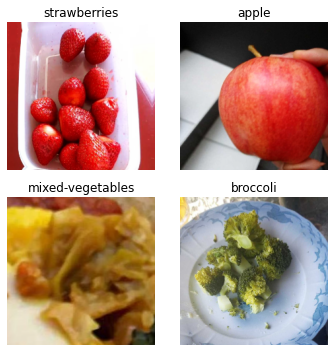

In [34]:
train_images.show_batch(rows=2, figsize=(5,5))

## Here we download and use the pretrained resnet50 

In [35]:
learn = cnn_learner(train_images, base_arch=models.resnet50 ,metrics=accuracy,pretrained=True)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


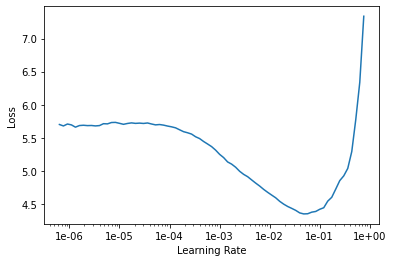

In [36]:
learn.lr_find()
learn.recorder.plot()

In [38]:
lr = 1e-3
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.901324,1.488675,0.559140,03:10
1,1.803495,1.303009,0.591398,03:12
2,1.694695,1.324033,0.612903,03:12
3,1.496669,1.371592,0.559140,03:12
4,1.331273,1.337718,0.580645,03:11
5,1.183915,1.293216,0.623656,03:12
6,1.061239,1.270755,0.569892,03:12
7,0.947379,1.286286,0.602151,03:12
8,0.842199,1.273870,0.580645,03:11
9,0.790030,1.268514,0.612903,03:12


In [41]:
learn.save('/content/drive/MyDrive/results/res50-pretrained')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


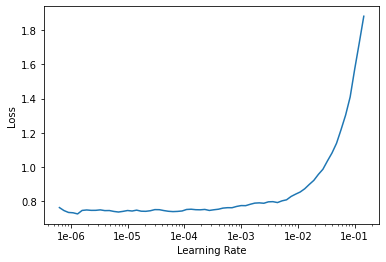

In [42]:
# learn.unfreeze() 
learn.lr_find()
learn.recorder.plot()                             # Unfreeze all layers
# learn.bn_freeze(True)                         # Freeze batch normalization parameters (standard deviation & mean)
# learn.fit_one_cycle(8, slice(1e-6,1e-3))

In [43]:
learn.fit_one_cycle(8, slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.824856,1.214373,0.623656,03:11
1,0.926703,1.303356,0.612903,03:11
2,0.990387,1.256997,0.634409,03:11
3,0.932343,1.260456,0.602151,03:11
4,0.854835,1.209385,0.634409,03:09
5,0.780357,1.227152,0.634409,03:10
6,0.689095,1.276680,0.580645,03:10
7,0.655172,1.262572,0.602151,03:10


In [44]:
test_preds,_ = learn.get_preds(ds_type=DatasetType.Test)

In [45]:
# test_preds.size()
# print(train_images.classes)
preds = np.argmax(test_preds, axis=1)
# print(preds)
label_preds = []
for i in preds:
    # print(i)
    i = i.cpu().numpy().tolist()
    label_preds.append(train_images.classes[i])

# print(label_preds)    
df = pd.DataFrame(label_preds,columns=['ClassName'])
df.to_csv('submission.csv',index=False)
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>